# Data Analysis Using DuckDB

Purpose: Explore realistic sales data using DuckDB for our data warehouse.

Important: Set the Jupyter kernel to .venv/Scripts/python.exe (our local Python) so it can find the external packages we installed into our local project .venv.

In [15]:
# Imports from Python Standard Library 
from pathlib import Path

# Imports from external packages (see requirements.txt)
# Create a local .venv and be sure these are installed.
# Select the VS Code Python interpreter from the .venv folder.
# Select the Jupyter kernel from the .venv folder.
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define project paths as constants
ROOT_PROJECT_FOLDER = Path.cwd().parent  # Up one level this folder
DW_FOLDER = ROOT_PROJECT_FOLDER / 'dw'
NOTEBOOKS_FOLDER = ROOT_PROJECT_FOLDER / 'notebooks'
SQL_FOLDER = ROOT_PROJECT_FOLDER / 'sql'
DW_FILE = DW_FOLDER / 'sales.duckdb'
SALES_SUMMARY_SQL_FILE = SQL_FOLDER / '22_sales_summary_by_category.sql'
print("Verify Project Paths - check these to ensure they are correct")
print(f"Root Folder:  {ROOT_PROJECT_FOLDER}")
print(f"DW  Folder:   {DW_FOLDER}")
print(f"NB  Folder:   {NOTEBOOKS_FOLDER}")
print(f"SQL Folder:   {SQL_FOLDER}")
print(f"DW File:      {DW_FILE}")
print(f"SQL File:     {SALES_SUMMARY_SQL_FILE}")


Verify Project Paths - check these to ensure they are correct
Root Folder:  c:\Users\edaci\Documents\smart-sales-duckdb-sql-python
DW  Folder:   c:\Users\edaci\Documents\smart-sales-duckdb-sql-python\dw
NB  Folder:   c:\Users\edaci\Documents\smart-sales-duckdb-sql-python\notebooks
SQL Folder:   c:\Users\edaci\Documents\smart-sales-duckdb-sql-python\sql
DW File:      c:\Users\edaci\Documents\smart-sales-duckdb-sql-python\dw\sales.duckdb
SQL File:     c:\Users\edaci\Documents\smart-sales-duckdb-sql-python\sql\22_sales_summary_by_category.sql


## Step 1. Connect and Inspect

In [16]:
# Connect to DuckDB
try:
    conn = duckdb.connect(database=str(DW_FILE), read_only=True)
    print(f"Successfully connected to DuckDB database: {DW_FILE}")
except duckdb.Error as e:
    print(f"Error connecting to DuckDB: {e}")
    exit()

# Inspect - use DuckDB SQL commands to SHOW TABLES
print("\n Tables in the Database")
tables_df = conn.execute("SHOW TABLES;").fetchdf()
print(tables_df)


Successfully connected to DuckDB database: c:\Users\edaci\Documents\smart-sales-duckdb-sql-python\dw\sales.duckdb

 Tables in the Database
                      name
0             dim_customer
1                 dim_date
2              dim_product
3     dim_product_category
4  dim_product_subcategory
5            dim_promotion
6                dim_store
7               fact_sales


## Step 2. Use SQL To Get Summary Totals

In [17]:
# OPTION 1: USE SQL EXPLICITLY

s = """SELECT 
    dim_product_category.ProductCategoryName AS category,
    SUM(fact_sales.SalesQuantity) AS total_quantity,
    SUM(fact_sales.SalesAmount) AS total_amount
FROM fact_sales
JOIN dim_product ON fact_sales.ProductKey = dim_product.ProductKey
JOIN dim_product_subcategory ON dim_product.ProductSubcategoryKey = dim_product_subcategory.ProductSubcategoryKey
JOIN dim_product_category ON dim_product_subcategory.ProductCategoryKey = dim_product_category.ProductCategoryKey
GROUP BY dim_product_category.ProductCategoryName
ORDER BY total_amount DESC
LIMIT 10;
"""
df = conn.execute(s).fetchdf()
print(df)

# OPTION 2: STORE SQL in a .sql FILE (RECOMMENDED)

# Step 1:  Define a reuseable function to call a query and get a dataframe
def get_dataframe_from_sql_file(sql_file_path: str, db_file_path: str) -> pd.DataFrame | None:
    """
    Executes the SQL query from the specified file against the DuckDB database
    and returns the result as a Pandas DataFrame.

    Args:
        sql_file_path: Path to the .sql file containing the SELECT query.
        db_file_path: Path to the DuckDB database file.

    Returns:
        A Pandas DataFrame containing the query results, or None if an error occurs.
    """

    try:
        conn = duckdb.connect(database=str(db_file_path), read_only=True)
        print(f"Successfully connected to DuckDB database: {db_file_path}")

        with open(sql_file_path, 'r') as file:
            sql_script = file.read().strip()
            result = conn.execute(sql_script)

            if result and result.description:
                df = result.fetchdf()
                print(f"\nSuccessfully executed SQL script '{sql_file_path}'.")
                print(df.head())  # Print the first few rows
                return df
            else:
                print(f"\nSuccessfully executed SQL script '{sql_file_path}'. No data to display.")
                return None

    except FileNotFoundError:
        print(f"Error: SQL file not found at {sql_file_path}")
        return None
    except duckdb.Error as e:
        print(f"DuckDB Error while executing SQL: {e}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None
    finally:
        if conn:
            conn.close()
            print("\nConnection to DuckDB database closed.")



# Step 2: Call the function and get a DataFrame back 
# Bonus: now we can do this to call any .sql file. 
sales_df = get_dataframe_from_sql_file(SALES_SUMMARY_SQL_FILE, DW_FILE)
if sales_df is None:
    print("Could not retrieve DataFrame.")
    exit()



                        category  total_quantity  total_amount
0                Home Appliances      10379472.0  3.922737e+09
1                      Computers       7736223.0  2.621439e+09
2        Cameras and camcorders        6351378.0  2.549018e+09
3                   TV and Video       3449196.0  1.360121e+09
4                    Cell phones      12670216.0  8.843510e+08
5  Music, Movies and Audio Books       1523415.0  1.658047e+08
6                          Audio       1353298.0  1.516144e+08
7                 Games and Toys       3720669.0  3.244233e+07
Successfully connected to DuckDB database: c:\Users\edaci\Documents\smart-sales-duckdb-sql-python\dw\sales.duckdb

Successfully executed SQL script 'c:\Users\edaci\Documents\smart-sales-duckdb-sql-python\sql\22_sales_summary_by_category.sql'.
                  category  total_quantity  total_amount
0          Home Appliances      10379472.0  3.922737e+09
1                Computers       7736223.0  2.621439e+09
2  Cameras and camc

## Step 3. Visualize the Sales Summary DataFrame


Columns in the DataFrame:
['category', 'total_quantity', 'total_amount']


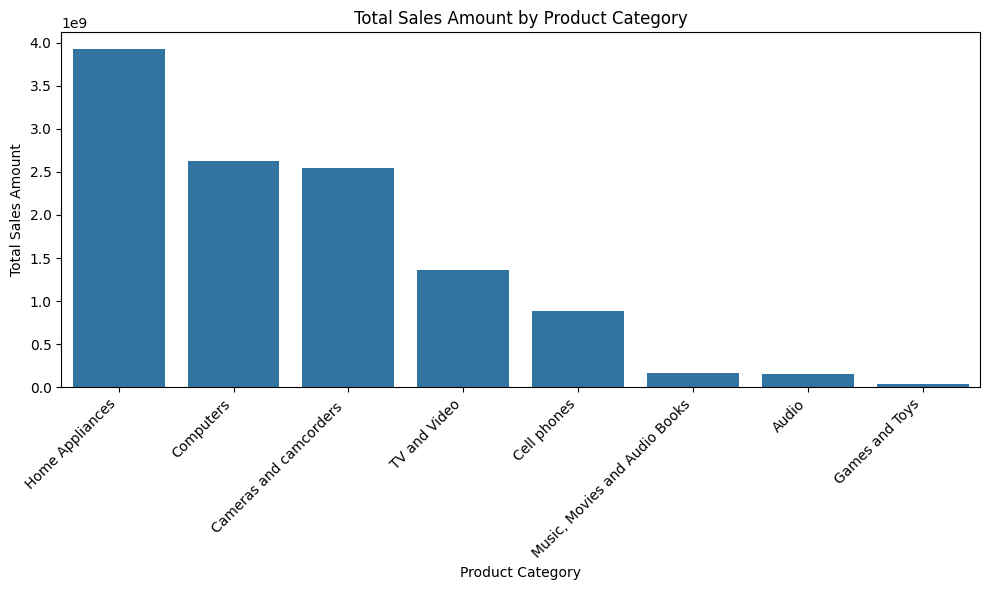

In [18]:
# Print the columns in the DataFrame
print("\nColumns in the DataFrame:")
print(sales_df.columns.tolist())   

# Use the actual column names
x_column = 'category'
y_column = 'total_amount'

# Validate columns exist
if x_column not in sales_df.columns or y_column not in sales_df.columns:
    print(f"Error: Required columns '{x_column}' and '{y_column}' not found in the DataFrame.")
    exit()

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=x_column, y=y_column, data=sales_df)
plt.xlabel("Product Category")
plt.ylabel("Total Sales Amount")
plt.title("Total Sales Amount by Product Category")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



## Step 99. Always Close the Database

In [19]:
# Final cleanup cell - after everything we want to do, be sure to close up. 
try:
    if conn:
        conn.close()
        print("Connection to DuckDB database closed.")
except NameError:
    print("No active connection found (already closed).")


Connection to DuckDB database closed.
